# 05.1 - Nesterov Accelerated Gradient (NAG) Optimiser

In this section, we look at how Nesterov's Accelerated Gradient (NAG) performs as our optimizer. This is partly inspired by [Sutskever et al. 2013](http://proceedings.mlr.press/v28/sutskever13.pdf) and [this stackoverflow](https://stackoverflow.com/questions/50774683/how-is-nesterovs-accelerated-gradient-descent-implemented-in-tensorflow) post on [TensorFlow's implementation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD) of NAG.

## <a href=#theory>Theory vs Implementation</a>

It is worth noting that the original NAG uses momentum to update weights. So for
- a weight $\theta_t$, <br>
- a loss function that we are minimizing $f(\cdot)$, 
- with gradient $\nabla f(\cdot)$, 
- momentum $\mu \in [0,1]$, 
- learning rate $\epsilon$, 
- and velocity $v_t$:

NAG is given by:
$$
\begin{eqnarray}
v_{t+1}^{(nag)} &=& \mu v_t^{(nag)} - \epsilon \nabla f(\theta_t + \mu vt) \\
\theta_{t+1}^{(nag)} &=& \theta_t + v_{t+1}^{(nag)} \\
                     &=& \theta_t + \mu v_t^{(nag)} - \epsilon \nabla f(\theta_t + \mu vt)
\end{eqnarray}
$$

However, TensorFlow documentation states:

`velocity = momentum * velocity - learning_rate * g `

`w = w + momentum * velocity - learning_rate * g `

Which would imply that we have:
$$
\begin{eqnarray}
\theta_{t+1}^{(nag)} &=& \theta_t + \mu v_{t+1}^{(nag)} - \epsilon \nabla f(\theta_t)\\
                     &=& \theta_t + \mu^2 v_t^{(nag)} - (1+\mu)\epsilon \nabla f(\theta_t)
\end{eqnarray}
$$

We think that this is either an error in the documentation print (although this description appears on the GitHub source description, too) and that the function actually takes:


$$
\begin{eqnarray}
\theta_{t+1}^{(nag)} &=& \theta_t + \mu v_t^{(nag)} - (1+\mu)\epsilon \nabla f(\theta_t)
\end{eqnarray}
$$

$$
\begin{eqnarray}
v_{t+1} &=& \mu v_t - \epsilon \nabla f(\theta_t) \\
\theta_{t+1}^{(tf)} &=& \theta_t + \mu v_{t+1}^{(tf)} - \epsilon \nabla f(\theta_t) 
\end{eqnarray}
$$


On the other hand, standard SGD in TensorFlow for $\mu > 0$ and $v_{t+1}$ described above is given by

$$
\begin{eqnarray}
\theta_{t+1} &=& \theta_t + v_{t+1}\\
             &=& \theta_t + \mu v_t - \epsilon \nabla f(\theta_t)
\end{eqnarray}
$$

Which is described in the Sutskever paper as Classical Momentum (CM).

And for $\mu = 0$ SGD is given by
$$
\begin{eqnarray}
\theta_{t+1} &=& \theta_t - \epsilon \nabla f(\theta_t)
\end{eqnarray}, 
$$



This serves as an approximation to NAG which holds for $\mu \approx 1$ and gradient condition $\nabla f(\theta_t) <<< \mu v_t$. However, the latter approximation does not always hold, though we can rectify this to some extent by choosing a very small learning rate $\epsilon$. Depending on the nature of our dataset, this may mean that the learning rate has to be so small for our gradient condition to be met that a true NAG optimizer would end up being slower. As a result, we will optimise for learning rate to pick the best-performing option, though this may mean that we end up with $\epsilon$ too large for our optimiser to be a true NAG optimiser.

This may mean that our results are not ideal compared to a true NAG optimiser, but we should hopefully see faster convergence than traditional gradient descent. Namely, NAG should converge at rate $\frac{1}{k^2}$ compared to traditional gradient descent which converges at $\frac{1}{k}$ where k is the number of steps taken.

We note also that NAG should theoretically shine more when the learning procedure takes more steps to converge to some optima, i.e. where the data is such that deep learning is truly needed and is not quickly/easily optimised by shallow learning methods as in that case our neural network would converge in very small values of $k$ such that $k$ and $k^2$ would not be easily distinguishable.

## Import

In [13]:
import time
import json

import random as python_random
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.metrics import TruePositives
from tensorflow.keras.metrics import KLDivergence

from mlxtend.plotting import plot_confusion_matrix

#for reproducibility, we set random seeds here
#Jupyter can sometimes assign seed value only in the cell that the random seed is called
#you can change this rseed value so the entire notebook changes seed values
rseed = 42

np.random.seed(rseed)
python_random.seed(rseed)
tf.random.set_seed(rseed)

## Load Data

In [2]:
#load the dataframes created in the Data.ipynb section
X_train = pd.read_csv('..\data\X_train.csv')
X_val = pd.read_csv('..\data\X_val.csv')
X_test = pd.read_csv('..\data\X_test.csv')

y_train_bin = pd.read_csv('..\data\y_train_bin.csv')
y_val_bin = pd.read_csv('..\data\y_val_bin.csv')
y_test_bin = pd.read_csv('..\data\y_test_bin.csv')

y_train_multi = pd.read_csv('..\data\y_train_multi.csv')
y_val_multi = pd.read_csv('..\data\y_val_multi.csv')
y_test_multi = pd.read_csv('..\data\y_test_multi.csv')

In [3]:
#turn string labels into float categories, categs is list of categories
y_train_multi, categs = pd.factorize(y_train_multi.connection_category)
y_val_multi, categs = pd.factorize(y_val_multi.connection_category)
y_test_multi, categs = pd.factorize(y_test_multi.connection_category)
#turn float categories into tf.keras matrix categories of dimension length(categs)
#e.g. 'normal' = [1,0,0,0,0]
y_train_multi = to_categorical(y_train_multi, num_classes = len(categs))
y_val_multi = to_categorical(y_val_multi, num_classes = len(categs))
y_test_multi = to_categorical(y_test_multi, num_classes = len(categs))

## Training

In [14]:
def binaryDNN(train_df = X_train, hidden_nodes = [10,10,10], op = 'adam', metrics = [tf.keras.metrics.AUC()]):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers 
    for i in hidden_nodes:
        #we use 'relu' as good, safe default for our neural nets
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(1, activation = 'sigmoid'))
    
    #compile model
    nn_model.compile(loss='binary_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

 

def multiDNN(train_df = X_train, num_classes = 5, hidden_nodes = [10,10,10], op = 'adam', 
             c_metrics = ['accuracy',TruePositives(),tfa.metrics.CohenKappa(num_classes=5)]):
    
    '''
    Function that takes dataframe train_df and creates a multiclass classifer neural network 
    with softmax output layers equal to the number of classes passed
    
    train_df = dataframe or array 
    num_classes = int, number of classes in the dataset
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final 
                   output layer containing num_classes softmax nodes
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    c_metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    #we initiate our model differently here, taking layers as a list
    #this is because of some issues when implementing when creating a neural net as above
    layers = []
    #input dimensions
    layers.append(Input(shape = (train_df.shape[1],)))
    
    #add layers with dropout
    for i in hidden_nodes:
        layers.append(Dense(i, activation = 'relu'))
        layers.append(Dropout(0.2))
        
    #output layer with number of nodes = num_classes
    layers.append(Dense(num_classes, activation = 'softmax'))
    
    nn_model = Sequential(layers)
    #compile model
    nn_model.compile(loss='categorical_crossentropy',optimizer=op,metrics=c_metrics)
    
    return nn_model

In [5]:
x1 = -np.arange(1,5)
epsilons = np.float_power(10,x1)

In [6]:
epsilons

array([0.1   , 0.01  , 0.001 , 0.0001])

Train binary and multiclass models for NAG, SGD, and Adam.

In [16]:
#Jupyter works a bit differently from a normal IDE 
#so we have to set random seed again in this cell
tf.random.set_seed(rseed)

#verbose variable
v = 0

count = 1
#number of times our model parses through the entire data it is given
epochs = 30
#number of data points the model goes through before updating next weight
batch_size = 500
start = time.time()

for eps in epsilons:
    #assign optimiser. Some are commented out and then used in other notebooks
    # sgd_opt = tf.keras.optimizers.SGD(learning_rate = eps,
    #                                   nesterov = False)

    nag_opt = tf.keras.optimizers.SGD(learning_rate = eps, 
                                      momentum = 0.9, 
                                      nesterov = True)
    
    
    # adam_opt = tf.keras.optimizers.Adam(learning_rate = eps)

    #this originally fit same model architecture for each optimizer ['sgd','nag','adam']
    #the list iteration format was kept because iterating over 1 variable does change runtime, realistically
    #we also wanted to demonstrate the code style were we to not face memory issues
    for opt in ['nag']:
        #assign optimizer as above
        optimizer = locals()['{}_opt'.format(opt)] 
        
        #compile model with appropriate optimizer
        bin_model_temp = binaryDNN(op = optimizer)
        #nicer preview/output readability
        print('-'*10 + 'Fitting binary model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        #record model history fitting to binary training data with validation split
        bin_history_temp = bin_model_temp.fit(X_train, y_train_bin,
                                              shuffle = True, validation_data = (X_val, y_val_bin),
                                              epochs = epochs, batch_size = batch_size,
                                              verbose = v)
        
        #assign models and their history to appropriately named variable in locals()
        locals()['{}_bin_model_{}'.format(opt,count)] = bin_model_temp
        locals()['{}_bin_history_{}'.format(opt,count)] = bin_history_temp
    
    
    
        #same as before but for multiclass categ
        categ_model_temp = multiDNN(op = optimizer)
        #nice print
        print('-'*10 + 'Fitting categorical model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        #fit model
        categ_history_temp = categ_model_temp.fit(X_train, y_train_multi,
                                                  shuffle = True, validation_data = (X_val, y_val_multi),
                                                  epochs = epochs, batch_size = batch_size,
                                                  verbose = v)
        #assign model and history to variables
        locals()['{}_categ_model_{}'.format(opt,count)] = categ_model_temp
        locals()['{}_categ_history_{}'.format(opt,count)] = categ_history_temp
         
    #delete temp model and history to free up memory
    del bin_model_temp
    del bin_history_temp
    del categ_model_temp
    del categ_history_temp
    print()
        
    #increase count for iteration on next epsilon value
    count += 1
    
end = time.time()

----------Fitting binary model to nag optimizer with learning rate 0.1----------
----------Fitting categorical model to nag optimizer with learning rate 0.1----------

----------Fitting binary model to nag optimizer with learning rate 0.01----------
----------Fitting categorical model to nag optimizer with learning rate 0.01----------

----------Fitting binary model to nag optimizer with learning rate 0.001----------
----------Fitting categorical model to nag optimizer with learning rate 0.001----------

----------Fitting binary model to nag optimizer with learning rate 0.0001----------
----------Fitting categorical model to nag optimizer with learning rate 0.0001----------



In [17]:
print('Time taken to run all models:  {:2f} seconds'.format(end-start))

Time taken to run all models:  909.627343 seconds


### Save Models and Histories

In [18]:
#create a folder called saved_models and one called saved_hists to prevent saving errors
!mkdir saved_models saved_hists

#since epsilons[0] corresponds to model_1 and epsilons[3] correponds to model_4 we use range(1, len(epsilons) + 1)
for i in range(1,len(epsilons)+1):
    
    #assign name to variable for better code readability later
    bin_name = '{}_bin_model_{}'.format(opt,i)
    categ_name = '{}_categ_model_{}'.format(opt,i)
    #save the binary and category models in saved_models folder
    locals()[bin_name].save('saved_models/{}'.format(bin_name))
    locals()[categ_name].save('saved_models/{}'.format(categ_name))

    #as above, for histories
    bin_hist = '{}_bin_history_{}'.format(opt,i)
    categ_hist = '{}_categ_history_{}'.format(opt,i)
    #call .history and dump using json
    json.dump(locals()[bin_hist].history, open('saved_hists/{}'.format(bin_hist), 'w'))
    json.dump(locals()[categ_hist].history, open('saved_hists/{}'.format(categ_hist), 'w'))    

A subdirectory or file saved_models already exists.
Error occurred while processing: saved_models.
A subdirectory or file saved_hists already exists.
Error occurred while processing: saved_hists.


INFO:tensorflow:Assets written to: saved_models/nag_bin_model_1\assets
INFO:tensorflow:Assets written to: saved_models/nag_categ_model_1\assets
INFO:tensorflow:Assets written to: saved_models/nag_bin_model_2\assets
INFO:tensorflow:Assets written to: saved_models/nag_categ_model_2\assets
INFO:tensorflow:Assets written to: saved_models/nag_bin_model_3\assets
INFO:tensorflow:Assets written to: saved_models/nag_categ_model_3\assets
INFO:tensorflow:Assets written to: saved_models/nag_bin_model_4\assets
INFO:tensorflow:Assets written to: saved_models/nag_categ_model_4\assets


## Load Models and Histories

In [19]:
#change this opt varfor each optimiser later
opt = 'nag'
#reassign same epsilons in case you do not want to run from above
x1 = -np.arange(1,5)
epsilons = np.float_power(10,x1)

#load as with the saving above
for i in range(1,len(epsilons)+1):
    bin_name = '{}_bin_model_{}'.format(opt,i)
    categ_name = '{}_categ_model_{}'.format(opt,i)
    
    locals()[bin_name] = tf.keras.models.load_model('saved_models/{}'.format(bin_name))
    locals()[categ_name] = tf.keras.models.load_model('saved_models/{}'.format(categ_name))
    
    bin_hist = '{}_bin_history_{}'.format(opt,i)
    categ_hist = '{}_categ_history_{}'.format(opt,i)
    
    locals()[bin_hist] = json.load(open('saved_hists/{}'.format(bin_hist), 'r'))
    locals()[categ_hist] = json.load(open('saved_hists/{}'.format(categ_hist), 'r'))

## Plots and Assessing Performance

### Binary Model

As we did with the SGD optimiser, we now look at the learning curves for the loss and scores for the NAG optimiser in the binary and multiclass scenario.

**Binary Loss**<br>
First, we look at the case for binary cross entropy, and we compare briefly to what we had for SGD

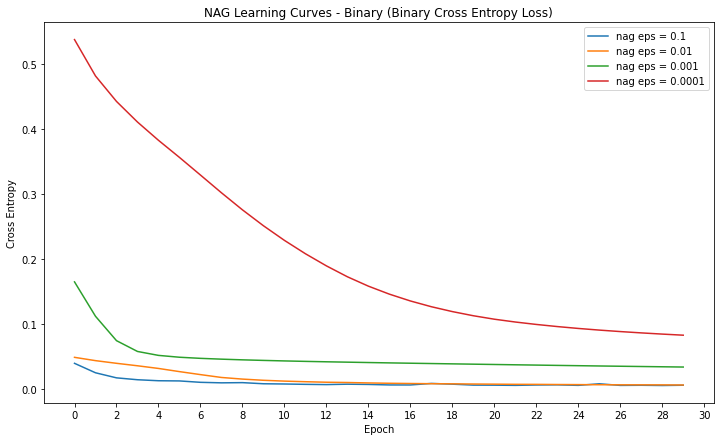

In [21]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Binary (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('Cross Entropy')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)]['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

The same behaviour as before persists; with learning rate of 0.1 performing better than the other learning rates, and convergence rate decreasing with learning rate. However, we do see that for the lower learning rates of 0.0001 and 0.001, the model does seem to converge more quickly than for the standard SGD. We plot them below to investigate.

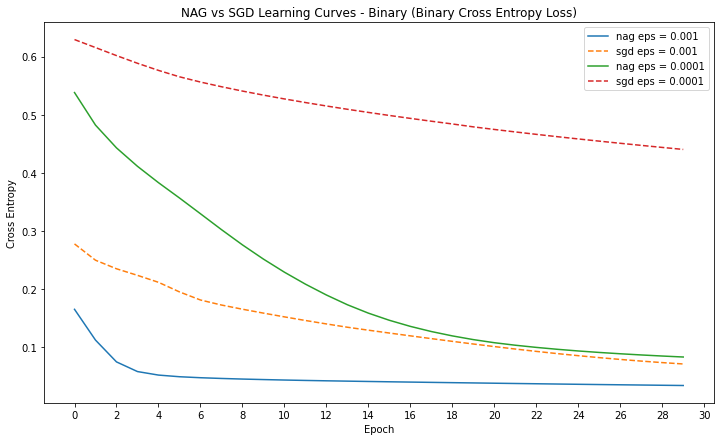

In [26]:
#load sgd histories
opt2 = 'sgd'
for i in range(3,len(epsilons)+1):
    bin_hist = '{}_bin_history_{}'.format(opt2,i)
    categ_hist = '{}_categ_history_{}'.format(opt2,i)
    
    locals()[bin_hist] = json.load(open('saved_hists/{}'.format(bin_hist), 'r'))
    locals()[categ_hist] = json.load(open('saved_hists/{}'.format(categ_hist), 'r'))
    
fig = plt.figure(figsize=(12,7))

plt.title('NAG vs SGD Learning Curves - Binary (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('Cross Entropy')

for count in range(3,len(epsilons)+1):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)]['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
    plt.plot(locals()['{}_bin_history_{}'.format(opt2,count)]['val_loss'],label='{} eps = {}'.format(opt2, epsilons[count-1]),ls='--')

plt.legend()
plt.show()

As we can see, NAG expectedly converged faster in loss than SGD. However, since we are monitoring convergence over epochs rather than number of training data, we do not see the extent of this rate. Concretely, NAG should converge at rate $\frac{1}{t^2}$ after $t$ steps, while SGD should converge at rate $\frac{1}{t}$ [[4]](https://blogs.princeton.edu/imabandit/2013/04/01/acceleratedgradientdescent/), and so if we plot seps, rather than epochs then this different would be more apparent theoretically (though figuring this out with TensorFlow was less clear and so we stick with plotting epochs).

One interesting observation to make about NAG as well is what we observe for learning rates of 0.1 and 0.01. We examine this below:

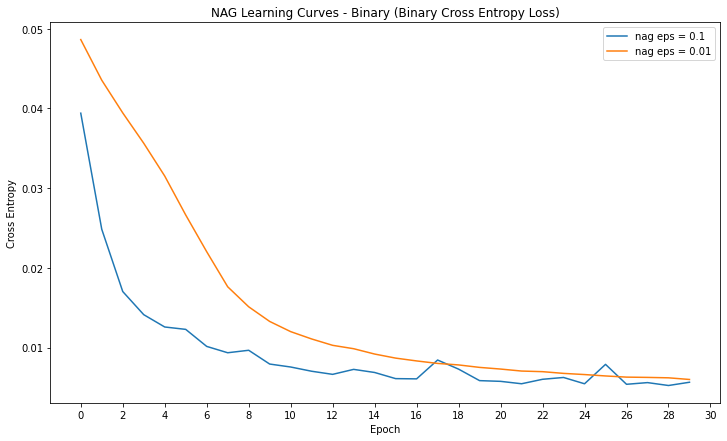

In [24]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Binary (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('Cross Entropy')

for count in range(1,len(epsilons)-1):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)]['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

As we can see, while a learning of 0.1 performed better for the first 15 epochs (and again, there's an argument to stop fitting both models at this point), we see spikes in loss and lower losses at certain points for the model with learning rate of 0.01. The expected and the most probaly reason for this is due to overfitting. It is worth noting that NAG does have increases in loss and not monotonic decrease (this can be seen between epochs 6 and 8 as well) and that this is expected because of the nature of the optimiser 'looking ahead' when minimising the gradient. Whether this is exactly what happens in TensorFlow, however, is unclear as the approximation is different from the description in the Sutskever et al. 2013 paper and specifically TensorFlow does not seem to employ the same 'looking ahead' feature of the optimiser. 

This is another challenge with both TensorFlow and this dataset that makes implementing early stopping epochs a challenge.

**AUC:**<br>
We now look at AUC, as before, to get a clearer idea of what the model is doing and add some interpretability.

In [20]:
#sometimes the val_auc would get renamed to val_auc_1 so this is to prevent errors below
auc = list(nag_bin_history_1.keys())[-1]
auc

'val_auc_1'

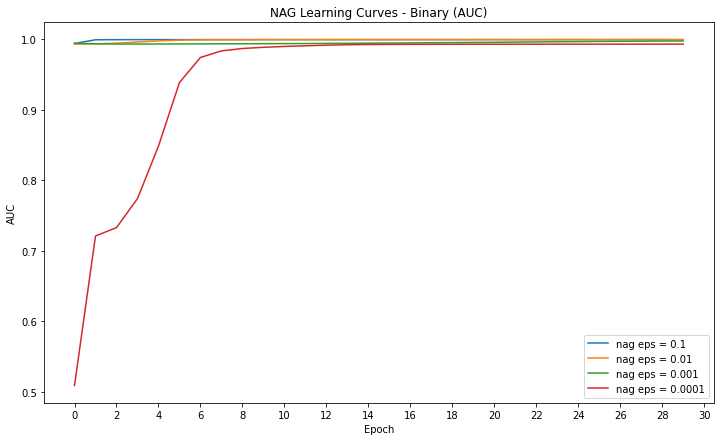

In [41]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Binary (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('AUC')


for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)][auc],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

We see very strong performance in terms of AUC for the 3 higher learning rates as we did with SGD, though the lowest learning rate achieves good performance very quickly (and indeed does better after 2 epochs than SGD does in 15), which we see below:

In [34]:
#to avoid the val_auc problem as mentioned above
sgd_auc = list(sgd_bin_history_4.keys())[-1]
sgd_auc

'val_auc'

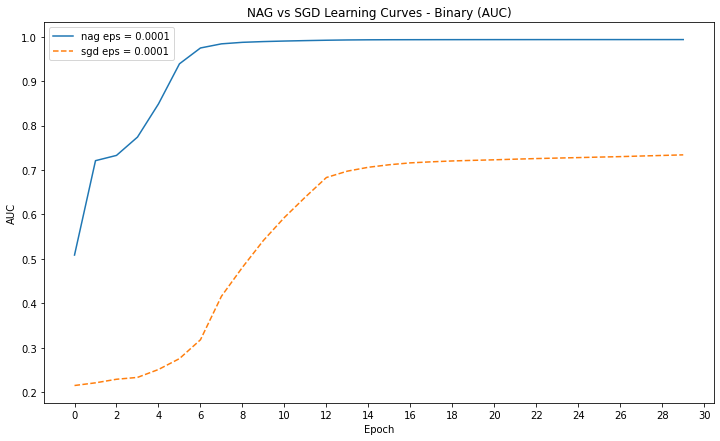

In [43]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG vs SGD Learning Curves - Binary (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('AUC')


plt.plot(locals()['{}_bin_history_4'.format(opt)][auc],label='{} eps = {}'.format(opt, epsilons[3]))
plt.plot(locals()['{}_bin_history_4'.format(opt2)][sgd_auc],label='{} eps = {}'.format(opt2, epsilons[3]),ls='--')

plt.legend()
plt.show()

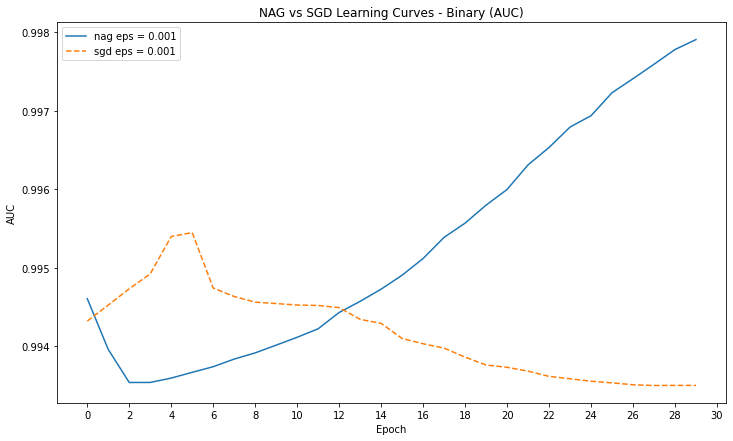

In [45]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG vs SGD Learning Curves - Binary (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('AUC')


plt.plot(locals()['{}_bin_history_3'.format(opt)][auc],label='{} eps = {}'.format(opt, epsilons[2]))
plt.plot(locals()['{}_bin_history_3'.format(opt2)][sgd_auc],label='{} eps = {}'.format(opt2, epsilons[2]),ls='--')

plt.legend()
plt.show()

The lower learning rate of 0.0001 reiterates what we saw and expected previously; a faster converge for NAG than SGD. The learning rate of 0.001 is a bit more interesting. We see NAG decreasing from epoch 0 to 2 and performing worse than SGD until epoch 12. When looking at the loss, however, NAG was attaining lower loss values throughout, which again is indicative of changing levels of certainty regarding categories but not necessarily category allocation. Again, it is not surprise for NAG to drop in performance before increasing based on what we know from theory but if we employed a stopping epoch based on loss, we would do this at epoch 2 for NAG (where it's doing worse in terms of AUC) andfor SGD at epoch 6 (where SGD is doing better than NAG) or aguably epoch 24 (where SGD is doing worse than NAG). 

Again, model and parameter choice really can be an art rather than science and we see different results based on choice here.

For completeness, we look at the two lower learning rates for NAG by themselves as we did previously.

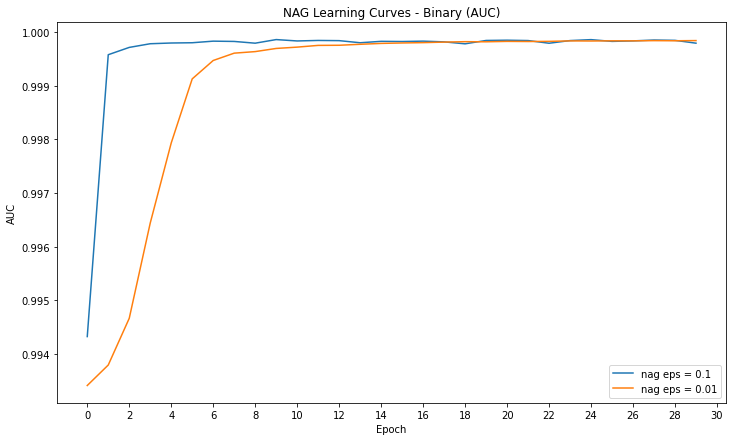

In [48]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Binary (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('AUC')


for count in range(1,len(epsilons)-1):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)][auc],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

Model with earning rate of 0.1 does better as before, with some dips below the model with learning rate 0.01 after around 15 epochs, as with the loss. The reasons for this have already been discussed.

**Confusion Matrix**<br>
We take a brief look at confusion matrices for completeness.

In [49]:
tf.random.set_seed(rseed)
nag_pred = nag_bin_model_1.predict(X_test)

In [50]:
nag_pred_bin = nag_pred
nag_pred_bin[nag_pred_bin>0.5]=1
nag_pred_bin[nag_pred_bin<0.5]=0

Text(0.5, 1.0, 'Confusion Matrix for nag with learning rate 0.1')

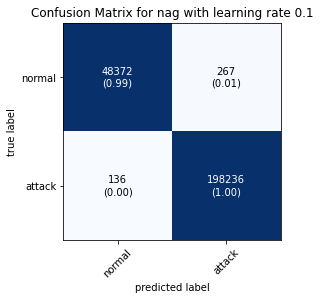

In [51]:
cmat_nag = confusion_matrix(y_test_bin,nag_pred)
cmat_nag

plot_confusion_matrix(
    conf_mat = cmat_nag,
    show_normed = True,
    class_names = ['normal','attack']
)

plt.title('Confusion Matrix for nag with learning rate {}'.format(epsilons[0]))

Again, the best performing model performs practically perfectly and there isn't much to say. 

## Categorical Model

We now look at the more interesting multiclass scenario.

**Categorical Cross Entropy**<br>
We start by looking at the loss for our models.

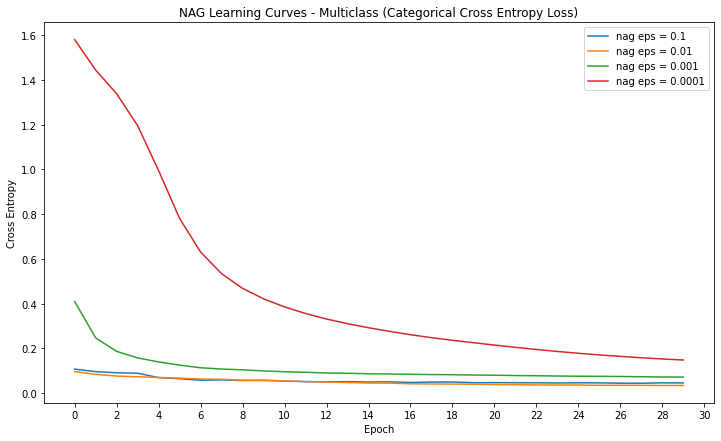

In [64]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Multiclass (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

The same behaviour as before persists, i.e. the rate of decrease of loss decreases with learning rate. As we saw in the binary case, our losses seem to drop at a much quicker rate than for SGD. We explore this for the lower learning rates for easier comparison below.

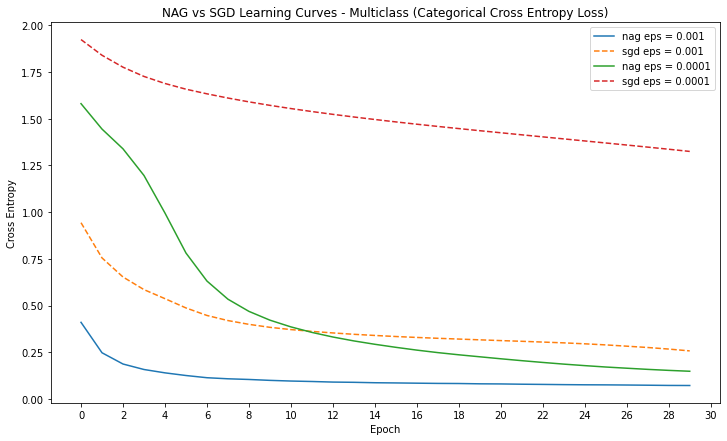

In [65]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG vs SGD Learning Curves - Multiclass (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('Cross Entropy')

for count in range(3,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))
    plt.plot(locals()['{}_categ_history_{}'.format(opt2,count)]['val_loss'],label='{} eps = {}'.format(opt2, epsilons[count-1]),ls='--')

plt.legend()
plt.show()

This is a more indicative graph of NAG vs SGD convergence than before, with the loss for a NAG with learning rate 0.0001 dropping below that of an SGD with learning rate of 0.001 after 11 epochs. This might be due to the different gradient properties in the multiclass scenario which allow for NAG to converge faster. Whether this is because there is more noise and NAG can look beyond the noise, or whether there is less noise but steeper gradients and the TensorFlow implementation for NAG creates more emphasised contributions by the gradient (as seen from the $(1+\mu) \epsilon \nabla f(\theta_t$ vs $\epsilon \nabla f(\theta_t)$ term highlighted in the [Theory vs Implementation](#theory) section of this notebook, is unclear. Either way, we see a faster rate of convergence with NAG.

For completeness, once more, we look at the two best performing learning rates:

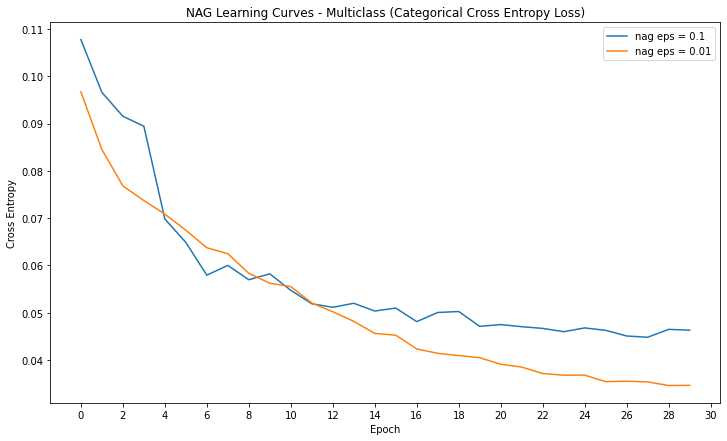

In [67]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Multiclass (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for count in range(1,len(epsilons)-1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

Interestingly we now see a much clearer divergence between the two higher learning rates, with a learning rate of 0.1 seemingly doing actively worse after 11 epochs. Again, how significant this is given the tiny values of loss, compared to whether this behaviour would persist for high loss values is not something we can immediately comment on.

**Categorical Accuracy**<br>
As before, we now take a look at categorical accuracy to interpret the loss convergence behaviour above.

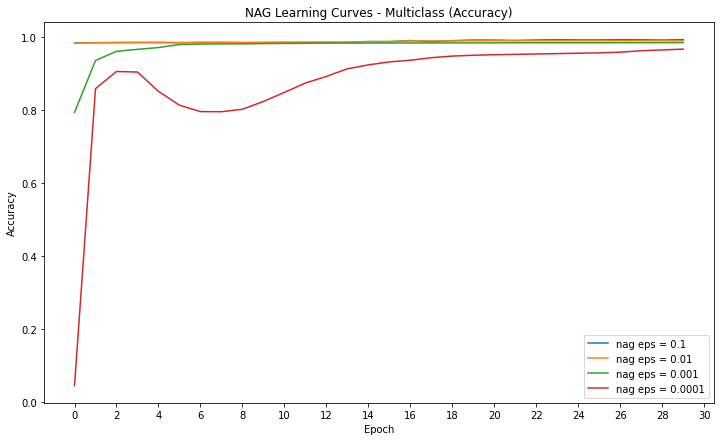

In [66]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Multiclass (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_accuracy'],
             label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

The stand-out point to look at here is clearly the drop in accuracy seen with the epsilon rate of 0.0001. Again, given an early stopping epoch, we could stop learning after 4 epochs, but we know that worse performance followed by better performance is not completely unexpected with NAG. However, what is interesting here is that this drop in accuracy corresponds with the sharpest loss drop and the accuracy going back up coincides with that slight flattening of that loss decrease. The reason for this is not entirely clear but it could be due to the existence of many sharp local minima, and the optimiser attempting to escape those. 

We would have liked to read up more on the theory and explore why these two scenarios would coincide in such a dramatic fashion and the reasonings behind it, including stopping the model at different epochs and comparing confusion matrices for each epoch to understand how the model shifts, but there was not enough time to do so.

We look at the higher learning rates for completeness below.

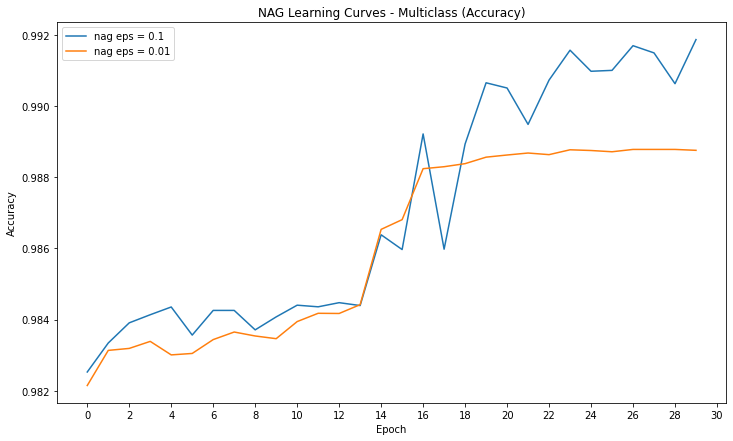

In [69]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Multiclass (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

for count in range(1,len(epsilons)-1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_accuracy'],
             label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

We see a lot of noise for both these learning rates and somewhat contrary to what we saw for the loss behaviour earlier, the learning rate of 0.1 performs better in terms of accuracy than a learning rate of 0.01. Again, this is likely due to the link between our loss function, certainty, and classification that we mentioned extensively before in this report.

**Cohen-Kappa Score:**<br>
We now look at the Cohen-Kappa measure as it is a more reliable metric than accuracy for an imbalanced dataset.

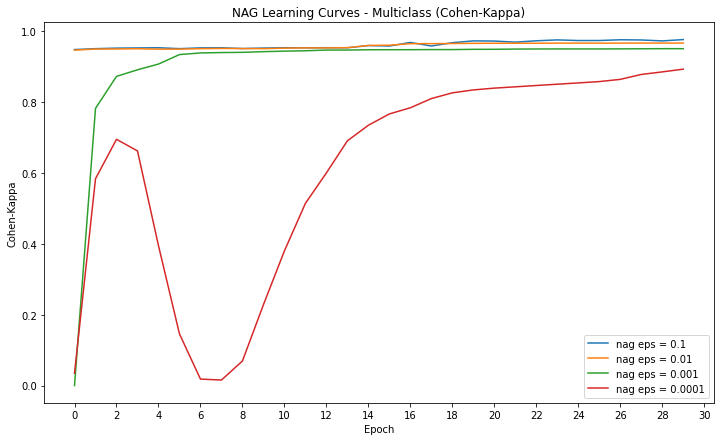

In [70]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Multiclass (Cohen-Kappa)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cohen-Kappa')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_cohen_kappa'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

Expectedly, we see the same behaviour as we saw for the loss, though the drop in Cohen-Kappa Score is much more dramatic than we would have expected compared to what we had for accuracy. Similar conclusions can be made to what we said above, and not much nne is left to say here other than the model shifting away from being the same 'rater' as the true labels briefly, before doing better after the initial drop.

Looking at the two higher learning rates, we have:

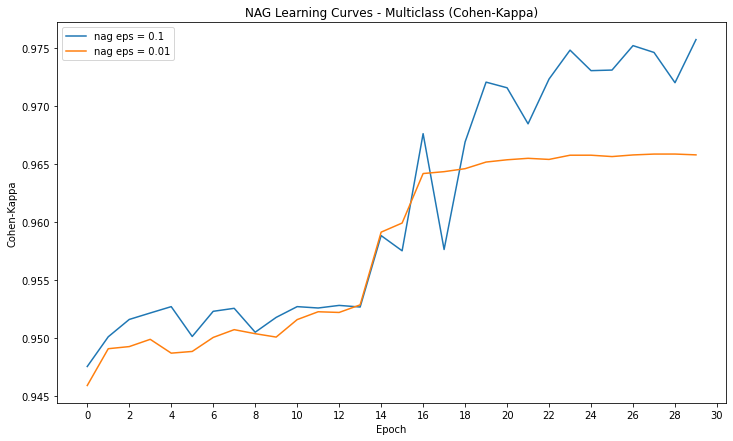

In [71]:
fig = plt.figure(figsize=(12,7))

plt.title('NAG Learning Curves - Multiclass (Cohen-Kappa)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cohen-Kappa')

for count in range(1,len(epsilons)-1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_cohen_kappa'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

The behaviour here is almost identical to that for accuracy. The unforunate reason for this is likely that the imbalance in our dataset is so large that accuracy and Cohen-Kappa become somewhat the same metric with slightly different axis ticks/values. 

**Confusion Matrices**<br>
For a better understanding and view of our models' performances given different learning rates, we now look at the confusion matrices.

In [55]:
tf.random.set_seed(rseed)

for i in range(len(epsilons)):
    
    model = locals()['nag_categ_model_{}'.format(i+1)]
    nag_categ_pred = model.predict(X_test)
    locals()['nag_categ_pred_{}'.format(i+1)] = nag_categ_pred

In [56]:
categs

Index(['dos', 'normal', 'probe', 'r2l', 'u2r'], dtype='object')

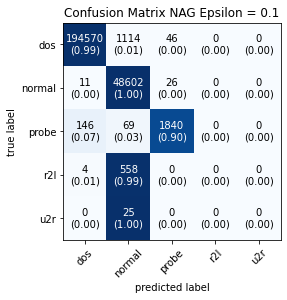

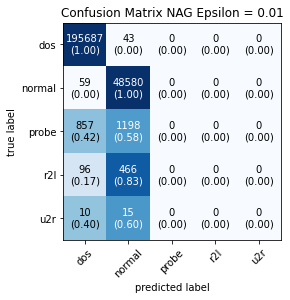

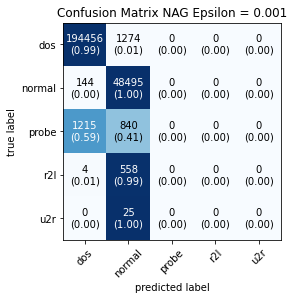

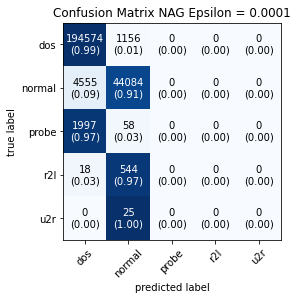

In [57]:
for i in range(len(epsilons)):
    nag_categ_pred = locals()['nag_categ_pred_{}'.format(i+1)]
    
    cmat_categ_nag = confusion_matrix(tf.argmax(y_test_multi,axis=1), tf.argmax(nag_categ_pred,axis=1))
    
    locals()['cmat_categ_nag_{}'.format(i)] = cmat_categ_nag
   
    
    plot_confusion_matrix(
        conf_mat = cmat_categ_nag,
        show_normed = True,
        class_names = categs
    )
    plt.title('Confusion Matrix {} Epsilon = {}'.format(opt.upper(),epsilons[i]))
    
del nag_categ_pred

We argue here that every learning rate performs better with a NAG optimiser than with an SGD optimiser. We do not plot all the confusion matrices here because the specific plot function used here behaves badly with subplots and plotting them all vertically becomes hectic, but comparing the two in different tabs should be easy enough. 

More interestingly, the NAG optimiser for a learning rate of 0.1 is actually able to classify probe attacks quite reliably (whereas SGD was never able to do so), though it still fails to capture r2l and u2r attacks. This is more understandable given just how infrequent these connections are in the dataset, but we could still argue that some overfitting was potentially done and that earlier stopping could have allowed for better performance. However, we do not explore this so cannot say for certain.

One thing that can be said, however, is that when we ran the models with a batch size of 1000 and no dropout rate, NAG was actually able to pick up probe attacks with a learning rate of 0.01 and some r2l attacks with a learning rate of 0.1. We displayed this to the supervisor but we did not save it or recreate it after making the new batch sizes choices and were not left with enough time to do so after seeing the performance change that came about. We do think, however, that this point is worth mentioning as it does raise the question of whether the use of dropout is appropriate here given the small datasize that we train on as well as the large class imbalances, or whether the larger batch sizes were the main reason for picking out r2l attacks and that these attacks exist in some sharp minima within our loss function. Concrertely, one could surmise that r2l and u2r are anomalous in our dataset to some degree and maybe larger batch sizes are better at picking them out as they converge to sharper minima and to some extent this may be overfitting in a sense. 

Overall, whether our current decision regarding dropout and batch size is correct, or whether the previous one was better is difficult to say. Given more time, experimenting with different dropouts, batch sizes, and monitoring their effect on generalising ability (maybe extending to the 100% dataset rather than sticking to just the 10%, for example) would be very interesting but that, again, lies beyond the scope of this work.

## References for Section 5.1

- [1] Ilya Sutskever, James Martens, George Dahl, Geoffrey Hinton Proceedings of the 30th International Conference on Machine Learning, PMLR 28(3):1139-1147, 2013 http://proceedings.mlr.press/v28/sutskever13.pdf
- [2] StackOverflow https://stackoverflow.com/questions/50774683/how-is-nesterovs-accelerated-gradient-descent-implemented-in-tensorflow 
- [3] TensorFlow SGD documentation (Nesterov) https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD)
- [4] Sebastien Bulbeck, ORF523: Nesterov’s Accelerated Gradient Descent https://blogs.princeton.edu/imabandit/2013/04/01/acceleratedgradientdescent/